In [1]:
import pandas as pd
import numpy as np
from scipy import stats

In [10]:
data = pd.read_csv("../../Data/Dataset_v0.csv",sep=";")

###  Catégoriser les types de variables :
 - Categorique ;
 - Numérique ;
 - Distance ;
 - Date

In [11]:
def categorisation(data,date_cols):
    distance = []
    date = []
    numerique = []
    categorique = []
    for col in data.columns:
        if data[col].dtypes == np.object:
            try:
                if str(type(eval(data[col][data[col].first_valid_index()]))) == "<class 'list'>":
                    distance.append(col)
                elif col in date_cols:
                    date.append(col)
                else:
                    categorique.append(col)
            except:
                if col in date_cols:
                    date.append(col)
                else:
                    categorique.append(col)
                
            
        else :
            numerique.append(col)
                
    return dict({"numerique":numerique,"categorique":categorique,"date":date,"distance":distance})

In [12]:
feat_cat = categorisation(data,["Listing Date"])
feat_cat

C:\Users\USER\AppData\Local\Temp/ipykernel_13688/292522503.py:7: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data[col].dtypes == np.object:


{'numerique': ['price',
  'Listing Number',
  'Floor Size',
  'Bathrooms',
  'Reception Rooms',
  'Price per m²',
  'Erf Size',
  'Levies',
  'Rates and Taxes',
  'Bedrooms',
  'Kitchens',
  'Lounges',
  'Dining Rooms',
  'Gardens',
  'Coverage',
  'Office',
  'Domestic Rooms'],
 'categorique': ['name',
  'province',
  'city',
  'address',
  'Type of Property',
  'Street Address',
  'Bedroom',
  'Bathroom 1',
  'Bathroom 2',
  'Kitchen',
  'Other',
  'Parking',
  'Garden',
  'Pool',
  'Security',
  'No Transfer Duty',
  'Pets Allowed',
  'Lifestyle',
  'Bedroom 1',
  'Bedroom 2',
  'Bedroom 3',
  'Bedroom 4',
  'Bathroom 3',
  'Dining Room',
  'Garage',
  'Lounge',
  'Bathroom',
  'Special Features',
  'Nearby Public Transport',
  'Description',
  'Family/TV Room',
  'Garage 1',
  'Garage 2',
  'Temperature Control',
  'Style',
  'Facing',
  'Roof',
  'Wall',
  'Window',
  'Entrance Hall',
  'Rooms',
  'Special Feature',
  'Outbuilding',
  'Flatlet',
  'Standalone Building',
  'Interne

## 1) Traitement des valeurs manquantes

### traitement par colonne

In [13]:
missing = pd.DataFrame([data.isna().sum().values,(data.isna().sum()/data.shape[0]).values],index = ["valeurs manquantes","% valeurs manquantes"] , columns=data.columns)
missing

,name,price,province,city,address,Listing Number,Type of Property,Street Address,Listing Date,Floor Size,...,Special Feature,Outbuilding,Flatlet,Standalone Building,Office,Domestic Rooms,Internet Access,Wheelchair Accessible,Parking 1,Parking 2
valeurs manquantes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9814.00000,0.0,5897.000000,...,12581.000000,13074.000000,13021.000000,12646.000000,13136.000000,12836.000000,12916.000000,13198.000000,13251.000000,13251.000000
% valeurs manquantes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.70005,0.0,0.420643,...,0.897425,0.932591,0.928811,0.902061,0.937014,0.915615,0.921321,0.941437,0.945217,0.945217


In [14]:
missing.T.describe()

,valeurs manquantes,% valeurs manquantes
count,73.000000,73.000000
mean,9179.424658,0.654785
std,4509.739208,0.321688
min,0.000000,0.000000
25%,6741.000000,0.480847
50%,10945.000000,0.780726
75%,12746.000000,0.909195
max,13251.000000,0.945217


#### On va supprimer certaines variables par seuil de valeurs manquantes mais sauver quelques variables pertinents au niveau métier :


In [15]:
def drop_columns(data,keep,drop,seuil):    
    missing = pd.DataFrame([data.isna().sum().values,(data.isna().sum()/data.shape[0]).values],index = ["valeurs manquantes","% valeurs manquantes"] , columns=data.columns)
    missing_freq = missing.T[missing.T["% valeurs manquantes"]>=seuil]
    print(len(missing_freq["% valeurs manquantes"]))
    (len(missing_freq["% valeurs manquantes"])/data.shape[1])*100

    for i in missing_freq.T.columns:
        ## variable à sauver
        if i not in keep:
            drop.append(i)
            
    return data.drop(drop,axis=1)

In [16]:
must_keep = feat_cat["distance"]+['price','Bathrooms','Levies','Rates and Taxes','Bedrooms','Kitchens','Garage',"Gardens",'Pool','Pets Allowed']
must_drop = ['Listing Number','Price per m²']+feat_cat["date"]

In [17]:
data = drop_columns(data,must_keep,must_drop,0.40)

59


In [18]:
data.shape

(14019, 21)

### 2) Traitement des valeurs aberrantes

### Détection par z-score (mbola tsy mety)

https://towardsdatascience.com/z-score-for-anomaly-detection-d98b0006f510

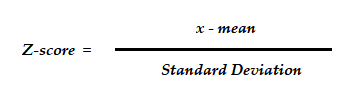


In [19]:
def z_score(data,columns,seuil):
    z_scores = stats.zscore(data[columns])
    print(z_scores)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < seuil).all(axis=1)
    data = data[filtered_entries]
    return data

### par IQR 

$$ IQR = Q3 - Q1 $$
$$ interval = [Q1 - seuil * IQR, Q3 + seuil * IQR]$$

In [20]:
def IQR(df,cols,quantiles=[0.25,0.75],seuil=1.5):
    Q1 = df[cols].quantile(quantiles[0])
    Q3 = df[cols].quantile(quantiles[1])
    IQR = Q3 - Q1

    return df[~((df[cols] < (Q1 - seuil * IQR)) |(df[cols] > (Q3 + seuil * IQR))).any(axis=1)]

Variables sur les prix (+ Listing Number) à ne pas vérifier : 
- 'price'

In [21]:
data.shape

(14019, 21)

In [22]:
feat_cat = categorisation(data,[""])
feat_cat

C:\Users\USER\AppData\Local\Temp/ipykernel_13688/292522503.py:7: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data[col].dtypes == np.object:


{'numerique': ['price',
  'Bathrooms',
  'Levies',
  'Rates and Taxes',
  'Bedrooms',
  'Kitchens',
  'Gardens'],
 'categorique': ['name',
  'province',
  'city',
  'address',
  'Type of Property',
  'Pool',
  'Pets Allowed',
  'Garage'],
 'date': [],
 'distance': ['Health',
  'Food and Entertainment',
  'Shopping',
  'Sports and Leisure',
  'Education',
  'Transport and Public Services']}

In [23]:
to_check = [ 'Bathrooms',
  'Levies',
  'Rates and Taxes',
  'Bedrooms',
  'Kitchens',
  'Gardens']

#data = z_score(data,to_check,1.)
data = IQR(data,to_check)
data.shape

(12423, 21)

### 3) Encodage :

- Pets Allowes en variable bool;
- Pool en variable bool;
- Garage en variable bool;
- Nan des variables catégoriques -> "missing"

In [24]:
data["Pets Allowed"].value_counts()

Yes    4030
No     2298
Name: Pets Allowed, dtype: int64

In [25]:
for pool in data["Pool"].value_counts().index:
    print(pool)

Yes
1
Communal Pool
Pool
Fenced, Communal Pool
Communal pool
Swimming pool
Chlorine pool
Chlorinator
Splash Pool
Auto Cleaning Equipment
Communal
Heated
Chlorine / swimming pool(s)
Communal swimming pool
Chlorine
Swimming
Fibreglass in Ground
Safety Net
Fenced
Own chlorine / swimming pool(s)
Fibreglass in Ground, Auto Cleaning Equipment
Gunite in Ground
Auto Cleaning Equipment, Chlorinator, Communal Pool
Auto Cleaning Equipment, Communal Pool
Auto Cleaning Equipment, Chlorinator
Own pool
Splash pool
Communal chlorine / swimming pool(s)
Communal chlorine pool
Fibreglass in Ground, Safety Net, Auto Cleaning Equipment
Communal, Swimming
Gunite in Ground, Communal Pool
Gunite in Ground, Auto Cleaning Equipment
Fenced, Auto Cleaning Equipment
Fenced, Auto Cleaning Equipment, Chlorinator, Communal Pool
Own swimming pool
Fibreglass in Ground, Safety Net
Own, Swimming
Heated pool
Communal chlorine / swimming pool(s) with cleaner
Heated, Communal Pool
Heated, Auto Cleaning Equipment
Fenced, Chl

In [26]:
for col in data.columns:
    if col == "Pets Allowed":
        data[col] = data[col].replace(np.nan,"missing")
    elif col == "Pool":
        data[col] = data[col].replace(r".*","y",regex=True)
        data[col] = data[col].replace(r"yy","Yes",regex=True)
        data[col] = data[col].replace(np.nan,"missing")
    elif col == "Garage":
        data[col] = data[col].replace(r".*","y",regex=True)
        data[col] = data[col].replace(r"yy","Yes",regex=True)
        data[col] = data[col].replace(np.nan,"missing")
    else :
        try :
            data[col] = pd.to_numeric(data[col])
        except:
            if col not in feat_cat["distance"]:
                data[col] = data[col].replace(np.nan,"missing")

In [27]:
data["Pets Allowed"].value_counts()

missing    6095
Yes        4030
No         2298
Name: Pets Allowed, dtype: int64

In [28]:
data["Pool"].value_counts()

missing    9614
Yes        2809
Name: Pool, dtype: int64

In [29]:
data.to_csv("../../Data/Dataset_v1.csv",sep=";",index=False)